# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import  roc_curve, roc_auc_score
import mlflow
from mlflow.models import infer_signature

In [2]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")

In [3]:
# Check duplicates
df.duplicated().sum()

np.int64(719)

In [4]:
# Drop duplicates
df.drop_duplicates(inplace=True)

<Axes: xlabel='booking_complete', ylabel='count'>

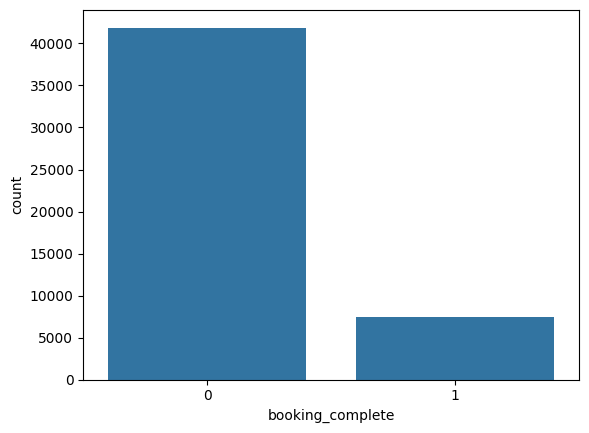

In [5]:
sns.countplot(data=df, x='booking_complete')

In [6]:
# data and label
data = df.copy()

In [7]:
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    data[col] = le.fit_transform(data[col])

In [8]:
X = data.drop('booking_complete', axis=1)
y = data['booking_complete']

In [9]:
y.value_counts()

booking_complete
0    41890
1     7391
Name: count, dtype: int64

In [10]:
undersample = RandomUnderSampler(random_state=0, sampling_strategy='majority', replacement=True)
X, y  = undersample.fit_resample(X, y)

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
data_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [12]:
kf = StratifiedKFold(n_splits=5)

**Note**
Because the data is imbalanced:
1. Use Cross Validation to split data
2. Use Random Forest For Modelling

In [13]:
def calculate_auc(X_test, y_test, model):
    y_pred = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_pred)
    return auc

def calculate_metrics(X_test, y_test, model):
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    return {'precision' : precision, 'recall' : recall, 'f1' : f1, 'accuracy' : accuracy}

def plot_roc_curves(X_test, y_test, model):
    y_pred = model.predict_proba(X_test)[:,1]
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {calculate_auc(X_test, y_test, model):.2f})')
        # Plot random classifier
    plt.plot([0,1],[0,1], linestyle='--', label='Random Classifier')
    plt.fill_between(fpr_rf, tpr_rf, color='#B9ECFF')

    # Format the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for British Airways Booking Completion')
    plt.legend()
    plt.show()

def display_most_important_features(model):
    data_feature = {'Feature':X.columns, 'Importance':model.feature_importances_}
    feature_contribution = pd.DataFrame(data_feature)
    feature_contribution.sort_values(by='Importance', ascending=True, inplace=True)
    feature_contribution.plot(x='Feature', y='Importance', rot=0, kind='barh')

# Modeling

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled , y,test_size=0.2, random_state=42)

In [15]:
params={
    'n_estimators': 250,
    'criterion': 'entropy',
    'max_depth': None,
    'max_features': 'sqrt'
}

In [16]:
rf = RandomForestClassifier(**params)
scores = cross_val_score(rf, X_train, y_train, cv=kf, scoring='precision')  # a list of error terms
cv_score = np.mean(scores)

In [17]:
rf.fit(X_train, y_train)
rf.feature_importances_

array([0.04566295, 0.01476876, 0.00319022, 0.17232198, 0.12826921,
       0.12947613, 0.08535982, 0.15583822, 0.13074101, 0.01759854,
       0.01838275, 0.02174315, 0.07664726])

0.7863315474747106
0.7076215505913273


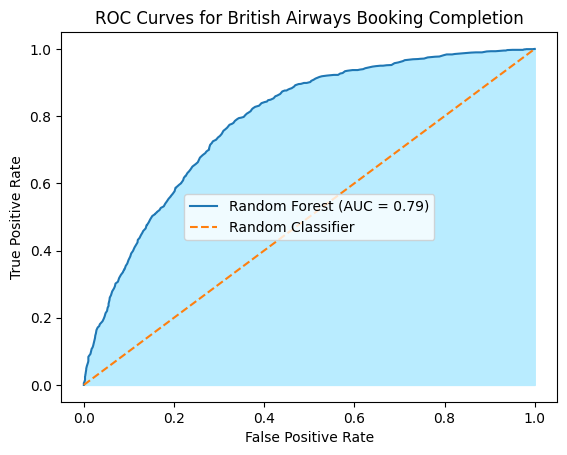

In [18]:
print(calculate_auc(X_test, y_test, rf))
print(calculate_metrics(X_test, y_test, rf)['precision'])
plot_roc_curves(X_test, y_test, rf)

In [ ]:
display_most_important_features(rf)

# Modelling (5 Features only)

In [ ]:
params={
    'n_estimators': 250,
    'criterion': 'entropy',
    'max_depth': None,
    'max_features': 'sqrt'
}

In [ ]:
new_data = data_scaled[['purchase_lead', 'route', 'booking_origin', 'flight_hour', 'length_of_stay']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_data , y,test_size=0.2, random_state=42)

In [ ]:
rf_5_features = RandomForestClassifier()

In [ ]:
scores = cross_val_score(rf_5_features, X_train, y_train, cv=kf, scoring='precision')  # a list of error terms
cv_score = np.mean(scores)

In [ ]:
rf_5_features.fit(X_train, y_train)

In [ ]:
print(calculate_auc(X_test, y_test, rf_5_features))
print(calculate_metrics(X_test, y_test, rf_5_features)['precision'])
plot_roc_curves(X_test, y_test, rf_5_features)

# Tracking with MLFLOW

In [19]:
EXPERIMENT_NAME = "Customer-Booking-Behavior-Prediction"
# # EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)

current_experiment=dict(mlflow.get_experiment_by_name(EXPERIMENT_NAME))
experiment_id=current_experiment['experiment_id']

In [20]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment(EXPERIMENT_NAME)

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("precision", calculate_metrics(X_test, y_test, rf)['accuracy'])
    mlflow.log_metric("recall", calculate_metrics(X_test, y_test, rf)['recall'])
    mlflow.log_metric("precision", calculate_metrics(X_test, y_test, rf)['precision'])
    mlflow.log_metric("f1-score", calculate_metrics(X_test, y_test, rf)['f1'])
    mlflow.log_metric("auc", calculate_auc(X_test, y_test, rf))
    mlflow.log_metric("precision_from_cv", cv_score)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("model_info", "RF with All Features")

    # Infer the model signature
    signature = infer_signature(X_train, rf.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=rf,
        artifact_path="booking_behavior_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="tracking-quickstart",
    )

Registered model 'tracking-quickstart' already exists. Creating a new version of this model...
2024/12/13 14:52:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: tracking-quickstart, version 13


🏃 View run overjoyed-mouse-842 at: http://127.0.0.1:5000/#/experiments/649532075471478813/runs/5b25bae157d5484d914dc5a199bcab6f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/649532075471478813


Created version '13' of model 'tracking-quickstart'.
